Esse script tem como objetivo treinar o algoritmo de machine learning, como a base de dados possuí muitos atributos, será feita a redução de dimensionalidade com o PCA, além disso, a base está desbalanceada na variável target, portanto será aplicado a técnica de SMOTE. A métrica de avaliação será a area under the ROC curve, mesma métrica utilizada na competição do Kaggle. Na descrição da competição no Kaggle o objetivo é prever a probabilidade de insatisfação do cliente, apesar da variável target na base de treino ser binária, a probabilidade pode assumir qualquer valor entre 0 e 1, sendo assim, para as predições de avaliação dos modelos será utilizado a predição probabilística. No final do script, as predições usando o melhor modelo serão feitas na base de testes da competição e submetidas ao Kaggle para avaliação do score. O objetivo final é um score mínimo de 0.8 no private leaderboard da competição no Kaggle.

In [1]:
#importando as bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#importando o dataframe de trabalho
df = pd.read_csv('data_work.csv')

In [3]:
#elimando a coluna ID
df.drop(columns="ID", inplace=True)

In [4]:
#aplicando pca nos dados
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

array = df.values

#separando o array em input e output
X = array[:,0:303]
Y = array[:,303]

#normalizando os dados
scaler = MinMaxScaler(feature_range = (0, 1))
rescaledX = scaler.fit_transform(X)

#aplicando PCA
pca = PCA(n_components = 10)
fitted_data = pca.fit_transform(rescaledX)

In [5]:
#dividindo os dados em treino e teste
from sklearn.model_selection import train_test_split
X_treino, X_teste, Y_treino, Y_teste = train_test_split(fitted_data, Y, test_size = 0.3, random_state=234)

In [6]:
#aplicando SMOTE nos dados de treino
from imblearn.over_sampling import SMOTE
sm = SMOTE(ratio='minority')

Xsm_train, ysm_train = sm.fit_sample(X_treino, Y_treino)

(array([51111.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 51111.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

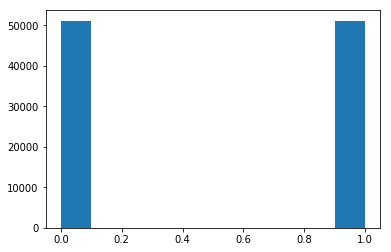

In [7]:
#distribuição dos dados de treino após SMOTE
plt.hist(ysm_train)

(array([51111.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2103.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

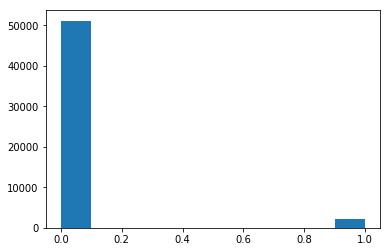

In [8]:
#distribuição dos dados de treino originais
plt.hist(Y_treino)

Conforme observado no primeiro gráfico, a base está mais balanceada para o processo de treinamento

In [9]:
#iniciando pelo algoritmo de regressão logistica
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr = LogisticRegression()

lr.fit(Xsm_train, ysm_train)
pred = lr.predict_proba(X_teste)[:,1]
scr_lr = roc_auc_score(Y_teste,pred)
scr_lr

0.7432060797950395

In [10]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB() 
nb.fit(Xsm_train, ysm_train)
pred = nb.predict_proba(X_teste)[:,1]
scr_nb = roc_auc_score(Y_teste,pred)
scr_nb

0.7093486485266067

In [11]:
#SVM
from sklearn import svm

svm = svm.SVC(probability=True)
svm.fit(Xsm_train, ysm_train)
pred = svm.predict_proba(X_teste)[:,1]
scr_svm = roc_auc_score(Y_teste,pred)
scr_svm

0.747550239261004

In [12]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(Xsm_train, ysm_train)
pred = rf.predict_proba(X_teste)[:,1]
scr_rf = roc_auc_score(Y_teste,pred)
scr_rf

0.7191665356989426

In [13]:
#XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(Xsm_train, ysm_train)
pred = xgb.predict_proba(X_teste)[:,1]
scr_xgb = roc_auc_score(Y_teste,pred)
scr_xgb

0.7758800085063852

Entre todos os algoritmos o XGBoost teve a melhor perfomance, para os próximos testes será usado o XGBoost para comparação dos resultados, ao final, para os dados que apresentarem o melhor resultado, será feito o ajuste dos hyperparâmetros do XGBoost buscando melhorar o score, com o melhor resultado será feita a aplicação do modelo na base de testes da competição.

In [14]:
#aumentando o número de componentes PCA
pca = PCA(n_components = 60)
fitted_data = pca.fit_transform(rescaledX)

In [15]:
#dividindo a base novamente em treino e teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(fitted_data, Y, test_size = 0.3, random_state=234)

In [16]:
#aplicando SMOTE na base de treinos
sm = SMOTE(ratio='minority')
Xsm_train, ysm_train = sm.fit_sample(X_treino, Y_treino)

In [17]:
#aplicando o XGboost novamente
xgb = XGBClassifier()
xgb.fit(Xsm_train, ysm_train)
pred = xgb.predict_proba(X_teste)[:,1]
scr_xgb = roc_auc_score(Y_teste,pred)
scr_xgb

0.758890799658231

Aumentanto o número de componentes o algoritmo piorou o score.

In [18]:
#treinando um modelo com todos os atributos, sem reduzir a dimensionalidade
X_treino, X_teste, Y_treino, Y_teste = train_test_split(rescaledX, Y, test_size = 0.3, random_state=234)

In [19]:
#aplicando SMOTE na base de treinos
sm = SMOTE(ratio='minority')
Xsm_train, ysm_train = sm.fit_sample(X_treino, Y_treino)

In [20]:
#aplicando o XGboost novamente
xgb = XGBClassifier()
xgb.fit(Xsm_train, ysm_train)
pred = xgb.predict_proba(X_teste)[:,1]
scr_xgb = roc_auc_score(Y_teste,pred)
scr_xgb

0.7907920145930418

Utilizando todos os atributos da base o score melhorou, será usado um método de seleção de atributos para buscar um score melhor

In [21]:
#serão usados 20% dos atributos, ou seja, 60 atributos
imp = pd.DataFrame({"Var" : df.columns[0:303], "Imp" : xgb.feature_importances_})
cols = imp.sort_values(by="Imp", ascending=False)[0:60].index

In [22]:
#passando para x os parâmetros selecionados
X = array[:,cols]
rescaledX = scaler.fit_transform(X)

In [23]:
#dividindo em treino e teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(rescaledX, Y, test_size = 0.3, random_state=234)

In [24]:
#aplicando SMOTE na base de treinos
sm = SMOTE(ratio='minority')
Xsm_train, ysm_train = sm.fit_sample(X_treino, Y_treino)

In [25]:
#aplicando o XGboost novamente
xgb = XGBClassifier()
xgb.fit(Xsm_train, ysm_train)
pred = xgb.predict_proba(X_teste)[:,1]
scr_xgb = roc_auc_score(Y_teste,pred)
scr_xgb

0.7912035097163755

O score teve uma leve melhora comparado ao modelo anterior, porém o score ainda está abaixo do desejado, nos próximos testes, será testado o algoritmo sem usar normalização e posteriormente sem SMOTE, para comparação dos resultados.

In [26]:
#treinando o algoritmo sem normalização dos dados
X_treino, X_teste, Y_treino, Y_teste = train_test_split(df.drop(columns="TARGET"), df["TARGET"], test_size = 0.3, random_state=234)

sm = SMOTE(ratio='minority')
Xsm_train, ysm_train = sm.fit_sample(X_treino, Y_treino)

xgb = XGBClassifier()
xgb.fit(Xsm_train, ysm_train)
pred = xgb.predict_proba(X_teste.values)[:,1]
scr_xgb = roc_auc_score(Y_teste,pred)
scr_xgb

0.8201488062428594

In [27]:
#treinando o algoritmo sem SMOTE
X_treino, X_teste, Y_treino, Y_teste = train_test_split(df.drop(columns="TARGET"), df["TARGET"], test_size = 0.3, random_state=234)

xgb = XGBClassifier()
xgb.fit(X_treino, Y_treino)
pred = xgb.predict_proba(X_teste)[:,1]
scr_xgb = roc_auc_score(Y_teste,pred)
scr_xgb

0.8295701071698585

O score melhorou quando aplicado sem SMOTE e sem a normalização dos dados, para efeito de comparação, será carregada a base de treino original, sem transformações, transformações serão feitas ao longo do processo de treinamento.

In [28]:
#carregando a base original
df  =  pd.read_csv('train.csv')

In [29]:
#elimando a coluna ID
df.drop(columns="ID", inplace=True)

In [30]:
#primeiro será treinado o modelo com todos os atributos, sem transformação, para avaliar o score
scaler = MinMaxScaler(feature_range = (0, 1))
rescaledX = scaler.fit_transform(df.drop(columns="TARGET"))

pca = PCA(n_components = 60)
fitted_data = pca.fit_transform(rescaledX)

X_treino, X_teste, Y_treino, Y_teste = train_test_split(fitted_data, df["TARGET"], test_size = 0.3, random_state=234)

sm = SMOTE(ratio='minority')
Xsm_train, ysm_train = sm.fit_sample(X_treino, Y_treino)

xgb = XGBClassifier()
xgb.fit(Xsm_train, ysm_train)
pred = xgb.predict_proba(X_teste)[:,1]
scr_xgb = roc_auc_score(Y_teste,pred)
scr_xgb

0.7691973246762618

In [31]:
#tirando os atributos zerados
ds = df.describe().T
df.drop(columns=ds.loc[(ds["min"]==0) & (ds["max"]==0),:].index, inplace=True)

In [32]:
#treinando o algoritmo sem os atributos zerados
scaler = MinMaxScaler(feature_range = (0, 1))
rescaledX = scaler.fit_transform(df.drop(columns="TARGET"))

pca = PCA(n_components = 60)
fitted_data = pca.fit_transform(rescaledX)

X_treino, X_teste, Y_treino, Y_teste = train_test_split(fitted_data, df["TARGET"], test_size = 0.3, random_state=234)

sm = SMOTE(ratio='minority')
Xsm_train, ysm_train = sm.fit_sample(X_treino, Y_treino)

xgb = XGBClassifier()
xgb.fit(Xsm_train, ysm_train)
pred = xgb.predict_proba(X_teste)[:,1]
scr_xgb = roc_auc_score(Y_teste,pred)
scr_xgb

0.770334637460738

Score melhorou quando tirados apenas os dados zerados comparando com a base contendo todos os atributos

In [33]:
#tirando os atributos correlacionados com outros atributos
cor = pd.melt(df.corr().reset_index(), id_vars='index', value_vars=df.columns, var_name='attr2', value_name='correlação')
cor.rename(columns={"index" : "attr1"},inplace=True)
#removendo os atributos duplicados e os comparativos com os próprios atributos
cor = cor.merge(pd.DataFrame({"attr1" : df.columns, "ind_attr1" : np.arange(0,len(df.columns))}),how="left",on="attr1")
cor = cor.merge(pd.DataFrame({"attr2" : df.columns, "ind_attr2" : np.arange(0,len(df.columns))}),how="left",on="attr2")
cor.drop(index=cor.loc[cor["ind_attr1"]>=cor["ind_attr2"],:].index,axis=1,inplace=True)
cor["corAbs"] = np.abs(cor["correlação"])
df.drop(columns=np.unique(cor.loc[cor["corAbs"]==1,["attr2"]]), inplace=True)

In [34]:
#treinando o algoritmo sem os atributos correlacionados
scaler = MinMaxScaler(feature_range = (0, 1))
rescaledX = scaler.fit_transform(df.drop(columns="TARGET"))

pca = PCA(n_components = 60)
fitted_data = pca.fit_transform(rescaledX)

X_treino, X_teste, Y_treino, Y_teste = train_test_split(fitted_data, df["TARGET"], test_size = 0.3, random_state=234)

sm = SMOTE(ratio='minority')
Xsm_train, ysm_train = sm.fit_sample(X_treino, Y_treino)

xgb = XGBClassifier()
xgb.fit(Xsm_train, ysm_train)
pred = xgb.predict_proba(X_teste)[:,1]
scr_xgb = roc_auc_score(Y_teste,pred)
scr_xgb

0.7764683920434523

Score melhorou quando tirados os atributos correlacionados comparando com a base sem os dados zerados. Nos próximos testes, será testado o algoritmo sem usar redução de dimensionalidade, sem normalização e também sem SMOTE, para comparação dos resultados.

In [35]:
#treinando o algoritmo sem redução de dimensionalidade
scaler = MinMaxScaler(feature_range = (0, 1))
rescaledX = scaler.fit_transform(df.drop(columns="TARGET"))

X_treino, X_teste, Y_treino, Y_teste = train_test_split(rescaledX, df["TARGET"], test_size = 0.3, random_state=234)

sm = SMOTE(ratio='minority')
Xsm_train, ysm_train = sm.fit_sample(X_treino, Y_treino)

xgb = XGBClassifier()
xgb.fit(Xsm_train, ysm_train)
pred = xgb.predict_proba(X_teste)[:,1]
scr_xgb = roc_auc_score(Y_teste,pred)
scr_xgb

0.7941624300815247

Score melhorou quando retirada a redução da dimensionalidade

In [36]:
#treinando o algoritmo sem normalização dos dados
X_treino, X_teste, Y_treino, Y_teste = train_test_split(df.drop(columns="TARGET"), df["TARGET"], test_size = 0.3, random_state=234)

sm = SMOTE(ratio='minority')
Xsm_train, ysm_train = sm.fit_sample(X_treino, Y_treino)

xgb = XGBClassifier()
xgb.fit(Xsm_train, ysm_train)
pred = xgb.predict_proba(X_teste.values)[:,1]
scr_xgb = roc_auc_score(Y_teste,pred)
scr_xgb

0.8175239860134039

Score melhorou quando retirada a normalização

In [37]:
#treinando o algoritmo sem SMOTE
X_treino, X_teste, Y_treino, Y_teste = train_test_split(df.drop(columns="TARGET"), df["TARGET"], test_size = 0.3, random_state=234)

xgb = XGBClassifier()
xgb.fit(X_treino, Y_treino)
pred = xgb.predict_proba(X_teste)[:,1]
scr_xgb = roc_auc_score(Y_teste,pred)
scr_xgb

0.8275682055941844

Score teve uma boa melhora sem o SMOTE

In [38]:
#ajustando os hyperparâmetros do algoritmo, além disso, será usado a auc como medida de avaliação durante o processo de 
#treinamento e também será usada a base de testes para validação
from sklearn.model_selection import RandomizedSearchCV
params = {
        'min_child_weight': [ 1, 3, 5, 7 ],
        'n_estimators' : [100, 150, 200, 250, 300],
        'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
        'max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15],
        'colsample_bytree' : [ 0.3, 0.5 , 0.65, 0.8, 0.9 ]
       }

rand_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=15)
rand_search.fit(X_treino, Y_treino, **{'early_stopping_rounds':5, 'eval_set':[(X_teste, Y_teste)], 'eval_metric':'auc'})

[0]	validation_0-auc:0.80635
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.81604
[2]	validation_0-auc:0.82295
[3]	validation_0-auc:0.82579
[4]	validation_0-auc:0.82995
[5]	validation_0-auc:0.83214
[6]	validation_0-auc:0.83563
[7]	validation_0-auc:0.83778
[8]	validation_0-auc:0.83568
[9]	validation_0-auc:0.83839
[10]	validation_0-auc:0.83857
[11]	validation_0-auc:0.83937
[12]	validation_0-auc:0.84098
[13]	validation_0-auc:0.84219
[14]	validation_0-auc:0.84265
[15]	validation_0-auc:0.84338
[16]	validation_0-auc:0.84334
[17]	validation_0-auc:0.84418
[18]	validation_0-auc:0.84476
[19]	validation_0-auc:0.84396
[20]	validation_0-auc:0.84392
[21]	validation_0-auc:0.84362
[22]	validation_0-auc:0.84400
[23]	validation_0-auc:0.84406
Stopping. Best iteration:
[18]	validation_0-auc:0.84476

[0]	validation_0-auc:0.80898
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.82351
[2]	validation_0-auc:0.82332
[3]	validation_0-auc

[10]	validation_0-auc:0.83692
[11]	validation_0-auc:0.83517
[12]	validation_0-auc:0.83506
Stopping. Best iteration:
[7]	validation_0-auc:0.83813

[0]	validation_0-auc:0.81318
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.82928
[2]	validation_0-auc:0.83508
[3]	validation_0-auc:0.83749
[4]	validation_0-auc:0.84123
[5]	validation_0-auc:0.84086
[6]	validation_0-auc:0.84017
[7]	validation_0-auc:0.83970
[8]	validation_0-auc:0.83931
[9]	validation_0-auc:0.83998
Stopping. Best iteration:
[4]	validation_0-auc:0.84123

[0]	validation_0-auc:0.81900
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.82366
[2]	validation_0-auc:0.82252
[3]	validation_0-auc:0.82970
[4]	validation_0-auc:0.83440
[5]	validation_0-auc:0.83016
[6]	validation_0-auc:0.82547
[7]	validation_0-auc:0.83292
[8]	validation_0-auc:0.83739
[9]	validation_0-auc:0.83181
[10]	validation_0-auc:0.83586
[11]	validation_0-auc:0.83459
[12]	validation_0-auc:0.83763
[1

[9]	validation_0-auc:0.83177
[10]	validation_0-auc:0.83516
[11]	validation_0-auc:0.83475
[12]	validation_0-auc:0.83801
[13]	validation_0-auc:0.84048
[14]	validation_0-auc:0.84201
[15]	validation_0-auc:0.84157
[16]	validation_0-auc:0.84254
[17]	validation_0-auc:0.84272
[18]	validation_0-auc:0.84333
[19]	validation_0-auc:0.84364
[20]	validation_0-auc:0.84401
[21]	validation_0-auc:0.84405
[22]	validation_0-auc:0.84396
[23]	validation_0-auc:0.84346
[24]	validation_0-auc:0.84353
[25]	validation_0-auc:0.84368
[26]	validation_0-auc:0.84328
Stopping. Best iteration:
[21]	validation_0-auc:0.84405

[0]	validation_0-auc:0.80840
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.82312
[2]	validation_0-auc:0.81300
[3]	validation_0-auc:0.81798
[4]	validation_0-auc:0.82822
[5]	validation_0-auc:0.81876
[6]	validation_0-auc:0.81535
[7]	validation_0-auc:0.82824
[8]	validation_0-auc:0.83302
[9]	validation_0-auc:0.82881
[10]	validation_0-auc:0.83334
[11]	validation_0-auc

[21]	validation_0-auc:0.84307
[22]	validation_0-auc:0.84181
[23]	validation_0-auc:0.84164
[24]	validation_0-auc:0.84182
[25]	validation_0-auc:0.84187
[26]	validation_0-auc:0.84210
Stopping. Best iteration:
[21]	validation_0-auc:0.84307

[0]	validation_0-auc:0.80310
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.80543
[2]	validation_0-auc:0.80423
[3]	validation_0-auc:0.81886
[4]	validation_0-auc:0.81962
[5]	validation_0-auc:0.81222
[6]	validation_0-auc:0.80989
[7]	validation_0-auc:0.82489
[8]	validation_0-auc:0.82785
[9]	validation_0-auc:0.82462
[10]	validation_0-auc:0.83152
[11]	validation_0-auc:0.82980
[12]	validation_0-auc:0.83373
[13]	validation_0-auc:0.83659
[14]	validation_0-auc:0.83923
[15]	validation_0-auc:0.84070
[16]	validation_0-auc:0.84174
[17]	validation_0-auc:0.84241
[18]	validation_0-auc:0.84276
[19]	validation_0-auc:0.84271
[20]	validation_0-auc:0.84345
[21]	validation_0-auc:0.84361
[22]	validation_0-auc:0.84337
[23]	validation_0-au

[3]	validation_0-auc:0.82968
[4]	validation_0-auc:0.83323
[5]	validation_0-auc:0.83266
[6]	validation_0-auc:0.83631
[7]	validation_0-auc:0.83827
[8]	validation_0-auc:0.83913
[9]	validation_0-auc:0.83518
[10]	validation_0-auc:0.83570
[11]	validation_0-auc:0.83618
[12]	validation_0-auc:0.83803
[13]	validation_0-auc:0.84041
[14]	validation_0-auc:0.84168
[15]	validation_0-auc:0.84240
[16]	validation_0-auc:0.84349
[17]	validation_0-auc:0.84395
[18]	validation_0-auc:0.84464
[19]	validation_0-auc:0.84375
[20]	validation_0-auc:0.84443
[21]	validation_0-auc:0.84467
[22]	validation_0-auc:0.84444
[23]	validation_0-auc:0.84454
[24]	validation_0-auc:0.84465
[25]	validation_0-auc:0.84457
[26]	validation_0-auc:0.84473
[27]	validation_0-auc:0.84465
[28]	validation_0-auc:0.84485
[29]	validation_0-auc:0.84476
[30]	validation_0-auc:0.84435
[31]	validation_0-auc:0.84419
[32]	validation_0-auc:0.84379
[33]	validation_0-auc:0.84386
Stopping. Best iteration:
[28]	validation_0-auc:0.84485

[0]	validation_0-auc

[13]	validation_0-auc:0.83776
Stopping. Best iteration:
[8]	validation_0-auc:0.83916

[0]	validation_0-auc:0.80801
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.81875
[2]	validation_0-auc:0.82443
[3]	validation_0-auc:0.82882
[4]	validation_0-auc:0.83178
[5]	validation_0-auc:0.83583
[6]	validation_0-auc:0.83804
[7]	validation_0-auc:0.83938
[8]	validation_0-auc:0.84049
[9]	validation_0-auc:0.84208
[10]	validation_0-auc:0.84142
[11]	validation_0-auc:0.84208
[12]	validation_0-auc:0.84280
[13]	validation_0-auc:0.84285
[14]	validation_0-auc:0.84383
[15]	validation_0-auc:0.84463
[16]	validation_0-auc:0.84401
[17]	validation_0-auc:0.84520
[18]	validation_0-auc:0.84521
[19]	validation_0-auc:0.84555
[20]	validation_0-auc:0.84512
[21]	validation_0-auc:0.84519
[22]	validation_0-auc:0.84526
[23]	validation_0-auc:0.84525
[24]	validation_0-auc:0.84532
Stopping. Best iteration:
[19]	validation_0-auc:0.84555

[0]	validation_0-auc:0.81171
Will train until validati

[18]	validation_0-auc:0.84576
[19]	validation_0-auc:0.84574
[20]	validation_0-auc:0.84534
[21]	validation_0-auc:0.84559
[22]	validation_0-auc:0.84498
[23]	validation_0-auc:0.84454
Stopping. Best iteration:
[18]	validation_0-auc:0.84576

[0]	validation_0-auc:0.81544
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.82633
[2]	validation_0-auc:0.83180
[3]	validation_0-auc:0.83362
[4]	validation_0-auc:0.83482
[5]	validation_0-auc:0.83655
[6]	validation_0-auc:0.83857
[7]	validation_0-auc:0.84024
[8]	validation_0-auc:0.84179
[9]	validation_0-auc:0.84033
[10]	validation_0-auc:0.84167
[11]	validation_0-auc:0.84024
[12]	validation_0-auc:0.84174
[13]	validation_0-auc:0.84313
[14]	validation_0-auc:0.84425
[15]	validation_0-auc:0.84494
[16]	validation_0-auc:0.84545
[17]	validation_0-auc:0.84596
[18]	validation_0-auc:0.84585
[19]	validation_0-auc:0.84510
[20]	validation_0-auc:0.84522
[21]	validation_0-auc:0.84473
[22]	validation_0-auc:0.84483
Stopping. Best itera

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster=None,
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=10...
                                           validate_parameters=False,
                                           verbosity=None),
                   iid='deprecated', n_iter=15, n_

In [39]:
pred = rand_search.predict_proba(X_teste)[:,1]
scr_xgb = roc_auc_score(Y_teste,pred)
scr_xgb

0.8431431648344219

O melhor estimador chegou em um score maior que 0.84 na base de testes, melhor score até então.

In [40]:
#criando um estimador com os parâmetros máximos do grid
xgb = XGBClassifier(n_estimators=300, max_depth=15,min_child_weight=7, colsample_bytree=0.9)
xgb.fit(X_treino, Y_treino, early_stopping_rounds=5, eval_metric="auc", eval_set=[(X_teste, Y_teste)])
pred = xgb.predict_proba(X_teste)[:,1]
scr_xgb = roc_auc_score(Y_teste,pred)
scr_xgb

[0]	validation_0-auc:0.82046
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.82903
[2]	validation_0-auc:0.83630
[3]	validation_0-auc:0.83693
[4]	validation_0-auc:0.83830
[5]	validation_0-auc:0.83964
[6]	validation_0-auc:0.84187
[7]	validation_0-auc:0.84023
[8]	validation_0-auc:0.83883
[9]	validation_0-auc:0.83897
[10]	validation_0-auc:0.83785
[11]	validation_0-auc:0.83722
Stopping. Best iteration:
[6]	validation_0-auc:0.84187



0.8418670809198903

Esse modelo teve uma leve queda de performance comparando com o melhor modelo com parâmetros aleatórios, testando esse modelo com uma taxa de aprendizado menor e early_stopping_rounds maior.

In [41]:
#criando um estimador com taxa de aprendizado menor e early_stopping_rounds maior
xgb = XGBClassifier(n_estimators=300, max_depth=15,min_child_weight=7, colsample_bytree=0.9, eta=0.01)
xgb.fit(X_treino, Y_treino, early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_teste, Y_teste)])
pred = xgb.predict_proba(X_teste)[:,1]
scr_xgb = roc_auc_score(Y_teste,pred)
scr_xgb

[0]	validation_0-auc:0.82046
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.82106
[2]	validation_0-auc:0.82209
[3]	validation_0-auc:0.82202
[4]	validation_0-auc:0.82293
[5]	validation_0-auc:0.82316
[6]	validation_0-auc:0.82389
[7]	validation_0-auc:0.82657
[8]	validation_0-auc:0.82842
[9]	validation_0-auc:0.82831
[10]	validation_0-auc:0.83043
[11]	validation_0-auc:0.83390
[12]	validation_0-auc:0.83378
[13]	validation_0-auc:0.83374
[14]	validation_0-auc:0.83361
[15]	validation_0-auc:0.83349
[16]	validation_0-auc:0.83388
[17]	validation_0-auc:0.83403
[18]	validation_0-auc:0.83457
[19]	validation_0-auc:0.83476
[20]	validation_0-auc:0.83455
[21]	validation_0-auc:0.83468
[22]	validation_0-auc:0.83479
[23]	validation_0-auc:0.83527
[24]	validation_0-auc:0.83543
[25]	validation_0-auc:0.83512
[26]	validation_0-auc:0.83604
[27]	validation_0-auc:0.83611
[28]	validation_0-auc:0.83653
[29]	validation_0-auc:0.83655
[30]	validation_0-auc:0.83704
[31]	validation_

0.845295315610352

A performance do modelo melhorou com relação ao anterior, sendo esse melhor que o melhor modelo com parâmetros aleatórios, será usado esse modelo para gerar o arquivo de submissão na base de testes da competição.

In [42]:
#aplicando o modelo na base de testes
test = pd.read_csv('test.csv')
test.drop(columns=ds.loc[(ds["min"]==0) & (ds["max"]==0),:].index, inplace=True)
test.drop(columns=np.unique(cor.loc[cor["corAbs"]==1,["attr2"]]), inplace=True)

In [43]:
pred = xgb.predict_proba(test.drop(columns="ID"))[:,1]

In [44]:
#criando o arquivo para submissão
sub = pd.DataFrame({"ID" : test["ID"], "TARGET": pred})
sub.to_csv("submission.csv", index = False)

Ao submeter o arquivo para a competição do Kaggle, o score no private leaderboard foi de 0.81544, ou seja, acima do objetivo proposto.